# Árboles de Decisión

**SI3015 - Fundamentos de Aprendizaje Automático**

En este cuaderno entrenaremos un Random Forest junto con un Gradient Boosting.

In [5]:
#Montamos el drive de google.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    PolynomialFeatures,
    FunctionTransformer,
)

In [7]:
# Definamos el `random_state`:
random_state = 42

In [8]:
# Cambiemos la fuente de las gráficas de matplotlib:
plt.rc('font', family='serif', size=12)

In [9]:
# Carguemos los datos:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML202610/sem6_arboles/used_cars.csv')
data

,brand_model,year,price,transmission,mileage,fuelType,tax,milesPerGallon,engineSize
0,Ford_Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1.0
1,Ford_Focus,2018,14000,Manual,9083,Petrol,150,57.7,1.0
2,Ford_Focus,2017,13000,Manual,12456,Petrol,150,57.7,1.0
3,Ford_Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
4,Ford_Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1.0
...,...,...,...,...,...,...,...,...,...
33117,VW_Eos,2012,5990,Manual,74000,Diesel,125,58.9,2.0
33118,VW_Fox,2008,1799,Manual,88102,Petrol,145,46.3,1.2
33119,VW_Fox,2009,1590,Manual,70000,Petrol,200,42.0,1.4
33120,VW_Fox,2006,1250,Manual,82704,Petrol,150,46.3,1.2


In [10]:
# Veamos la descripción del dataset:
data.describe(include='all')

,brand_model,year,price,transmission,mileage,fuelType,tax,milesPerGallon,engineSize
count,33122,33122.000000,33122.000000,33122,33122.000000,33122,33122.000000,33122.000000,33122.000000
unique,50,NaN,NaN,3,NaN,5,NaN,NaN,NaN
top,Ford_Fiesta,NaN,NaN,Manual,NaN,Petrol,NaN,NaN,NaN
freq,6557,NaN,NaN,24934,NaN,20731,NaN,NaN,NaN
mean,NaN,2017.044683,14366.095797,NaN,22782.077592,NaN,113.064428,56.006241,1.465168
std,NaN,2.060700,6698.673164,NaN,20266.265383,NaN,62.688154,12.043983,0.463069
min,NaN,1996.000000,495.000000,NaN,1.000000,NaN,0.000000,0.300000,0.000000
25%,NaN,2016.000000,9750.000000,NaN,8207.000000,NaN,30.000000,48.700000,1.000000
50%,NaN,2017.000000,12880.000000,NaN,17506.000000,NaN,145.000000,56.500000,1.500000
75%,NaN,2019.000000,17798.000000,NaN,31398.500000,NaN,145.000000,62.800000,2.000000


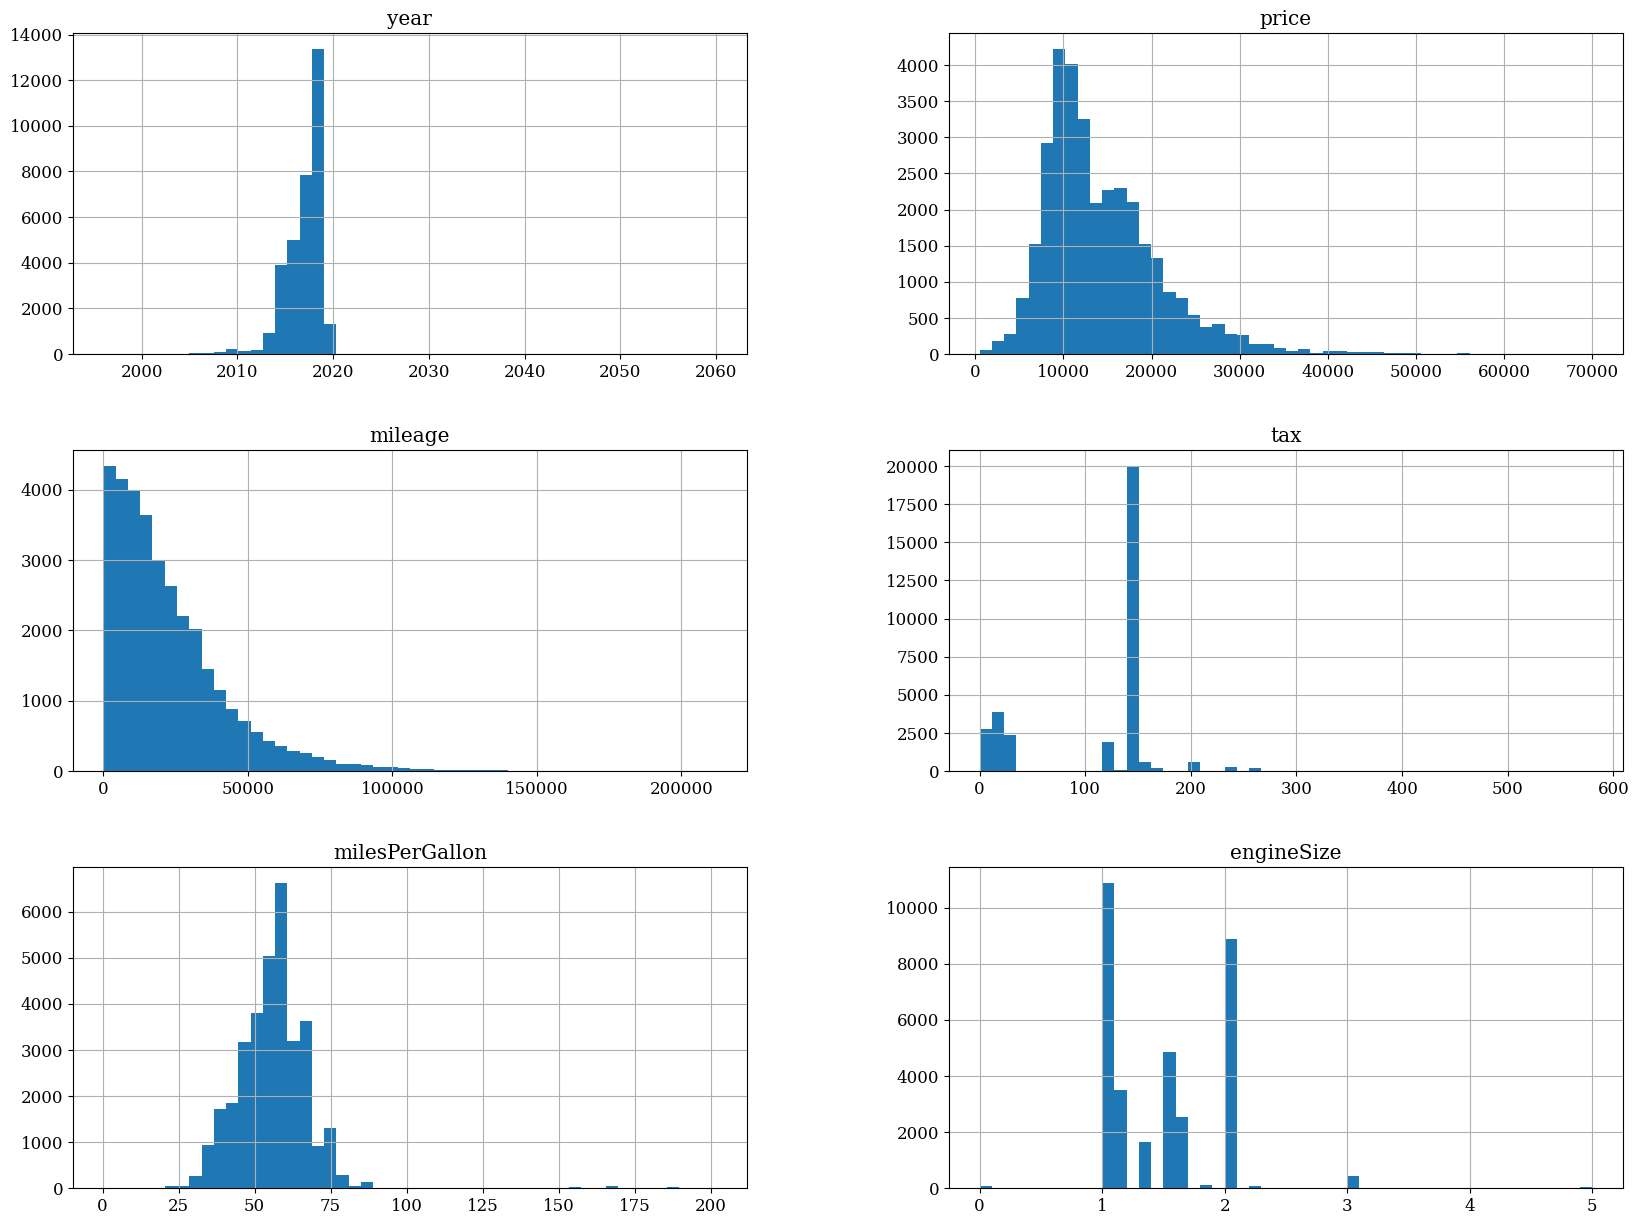

In [11]:
# Información de las columnas
data.hist(bins=50, figsize=(20, 15));

In [12]:
# El valor mínimo de `engineSize` no tiene sentido.
# Veamos cuántos registros son anómalos:
data[data.engineSize < 1]

,brand_model,year,price,transmission,mileage,fuelType,tax,milesPerGallon,engineSize
13862,Ford_Kuga,2019,18990,Manual,8389,Petrol,150,35.3,0.0
14064,Ford_Focus,2016,15500,Manual,28344,Diesel,20,67.3,0.0
14082,Ford_Focus,2015,14300,Manual,40457,Diesel,20,67.3,0.0
15343,Ford_KA,2018,10000,Manual,10051,Petrol,150,43.5,0.0
15500,Ford_EcoSport,2015,8500,Manual,33403,Diesel,30,61.4,0.0
...,...,...,...,...,...,...,...,...,...
29613,VW_Tiguan,2016,15300,Manual,38398,Diesel,145,53.3,0.0
29620,VW_Tiguan,2018,24000,Automatic,22200,Diesel,145,47.9,0.0
30786,VW_Up,2017,8500,Manual,20324,Petrol,20,64.2,0.0
30844,VW_Up,2017,8000,Manual,24444,Petrol,20,60.1,0.0


In [13]:
# Eliminemos los registros con tamaño del motor menor a 1 litro:
data.drop(index=data[data.engineSize < 1].index, inplace=True)

In [14]:
# Veamos la nueva descripción de la columna `engineSize`:
data.engineSize.describe()

,engineSize
count,33056.000000
mean,1.468094
std,0.458875
min,1.000000
25%,1.000000
50%,1.500000
75%,2.000000
max,5.000000


In [15]:
# El valor máximo del año tampoco tiene sentido.
# Veamos cuántos registros son anómalos:
data[data['year'] > 2020]

,brand_model,year,price,transmission,mileage,fuelType,tax,milesPerGallon,engineSize
17726,Ford_Fiesta,2060,6495,Automatic,54807,Petrol,205,42.8,1.4


In [16]:
# Eliminemos los registros con tamaño del motor menor a 1 litro:
data.drop(index=data[data.engineSize < 1].index, inplace=True)

In [17]:
# Eliminemos el registro con año mayor que 2020:
data.drop(index=data[data['year'] > 2020].index, inplace=True)

In [18]:
# Veamos la nueva descripción de la columna `year`:
data['year'].describe()

,year
count,33055.000000
mean,2017.042777
std,2.048155
min,1996.000000
25%,2016.000000
50%,2017.000000
75%,2019.000000
max,2020.000000


In [19]:
# Analicemos la distribución de los valores de la columna `transmission`:
data.transmission.value_counts()

,count
transmission,
Manual,24877
Semi-Auto,4867
Automatic,3311


In [20]:
# Analicemos la distribución de los valores de la columna `fuelType`:
data.fuelType.value_counts()

,count
fuelType,
Petrol,20677
Diesel,12122
Hybrid,166
Other,88
Electric,2


In [21]:
# Hay muy pocos automóviles eléctricos; agreguémoslos a la categoría `Other`:
# Custom Transformer class
class MergeElectricToOther(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy[self.column_name] = X_copy[self.column_name].replace('Electric', 'Other')
        return X_copy


In [22]:
# Create the pipeline
pipeline = Pipeline([
    ('merge_electric_to_other', MergeElectricToOther(column_name='fuelType'))
])

# Fit and transform the data
df_transformed = pipeline.fit_transform(data)
print(df_transformed)

       brand_model  year  price transmission  mileage fuelType  tax  \
0      Ford_Fiesta  2017  12000    Automatic    15944   Petrol  150   
1       Ford_Focus  2018  14000       Manual     9083   Petrol  150   
2       Ford_Focus  2017  13000       Manual    12456   Petrol  150   
3      Ford_Fiesta  2019  17500       Manual    10460   Petrol  145   
4      Ford_Fiesta  2019  16500    Automatic     1482   Petrol  145   
...            ...   ...    ...          ...      ...      ...  ...   
33117       VW_Eos  2012   5990       Manual    74000   Diesel  125   
33118       VW_Fox  2008   1799       Manual    88102   Petrol  145   
33119       VW_Fox  2009   1590       Manual    70000   Petrol  200   
33120       VW_Fox  2006   1250       Manual    82704   Petrol  150   
33121       VW_Fox  2007   2295       Manual    74000   Petrol  145   

       milesPerGallon  engineSize  
0                57.7         1.0  
1                57.7         1.0  
2                57.7         1.0  
3  

In [23]:
df_transformed.fuelType.value_counts()

,count
fuelType,
Petrol,20677
Diesel,12122
Hybrid,166
Other,90


In [24]:
# Apliquemos "ordinal encoding" a las características categóricas
# (dado que usaremos modelos basados en árboles de decisión):

#Encontrar variables numéricas y categóricas
cat_cols = data.select_dtypes(include=object).columns
num_cols = data.select_dtypes(include=np.number).columns

categorical_transformer = Pipeline(
    steps=[("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))]
)

In [25]:
encoder = categorical_transformer.fit(data.loc[:,cat_cols])
encoder["encoder"].categories_

[array(['Ford_B-MAX', 'Ford_C-MAX', 'Ford_EcoSport', 'Ford_Edge',
        'Ford_Escort', 'Ford_Fiesta', 'Ford_Focus', 'Ford_Fusion',
        'Ford_Galaxy', 'Ford_Grand C-MAX', 'Ford_Grand Tourneo Connect',
        'Ford_KA', 'Ford_Ka+', 'Ford_Kuga', 'Ford_Mondeo', 'Ford_Mustang',
        'Ford_Puma', 'Ford_Ranger', 'Ford_S-MAX', 'Ford_Streetka',
        'Ford_Tourneo Connect', 'Ford_Tourneo Custom',
        'Ford_Transit Tourneo', 'VW_Amarok', 'VW_Arteon', 'VW_Beetle',
        'VW_CC', 'VW_Caddy', 'VW_Caddy Life', 'VW_Caddy Maxi',
        'VW_Caddy Maxi Life', 'VW_California', 'VW_Caravelle', 'VW_Eos',
        'VW_Fox', 'VW_Golf', 'VW_Golf SV', 'VW_Jetta', 'VW_Passat',
        'VW_Polo', 'VW_Scirocco', 'VW_Sharan', 'VW_Shuttle', 'VW_T-Cross',
        'VW_T-Roc', 'VW_Tiguan', 'VW_Tiguan Allspace', 'VW_Touareg',
        'VW_Touran', 'VW_Up'], dtype=object),
 array(['Automatic', 'Manual', 'Semi-Auto'], dtype=object),
 array(['Diesel', 'Electric', 'Hybrid', 'Other', 'Petrol'], dtype=object

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns='price'),
    data.price, test_size=0.2,
    random_state=random_state
)

In [27]:
#Definimos nuestro Pipeline de pre-procesamiento
preprocessor = ColumnTransformer(
    transformers = [
       ('cat',categorical_transformer,cat_cols)
      ])

#Definimos nuestro regresor
rf_base = RandomForestRegressor(random_state=random_state)
gb_base = GradientBoostingRegressor(random_state=random_state)

pipeline_rf = Pipeline(steps = [
    ('merge_electric_to_other', MergeElectricToOther(column_name='fuelType')),
    ('preprocessor', preprocessor),
    ('regressor', rf_base),
                            ])

pipeline_gb = Pipeline(steps = [
    ('merge_electric_to_other', MergeElectricToOther(column_name='fuelType')),
    ('preprocessor', preprocessor),
    ('regressor', gb_base),
    ])

# Definamos la malla de parámetros sobre la que haremos la búsqueda:
param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': list(range(6, 10)),
    'regressor__min_samples_leaf': [10, 300, 2000]
}

# Definamos nuestros modelo mediante GridSearchCV:
rf = GridSearchCV(pipeline_rf, cv=3, param_grid=param_grid)
gb = GridSearchCV(pipeline_gb, cv=3, param_grid=param_grid)

In [28]:
%%time
# Entrenemos el random forest:
rf.fit(X_train, y_train)
# Entrenemos el gradient boosting:
gb.fit(X_train, y_train)

CPU times: user 1min 11s, sys: 144 ms, total: 1min 12s
Wall time: 1min 13s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('merge_electric_to_other',
                                        MergeElectricToOther(column_name='fuelType')),
                                       ('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         Index(['brand_model', 'transmission', 'fuelType'], dtype='object'))])),
                                       ('regressor',
                                        GradientBoostingRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [6, 7, 8, 9],
                         'regressor__min_samples_leaf': [10, 300, 2000],
                         'regressor__n_estimators': [50, 100]})

In [29]:
print(rf.best_params_)
print(gb.best_params_)

{'regressor__max_depth': 9, 'regressor__min_samples_leaf': 10, 'regressor__n_estimators': 100}
{'regressor__max_depth': 9, 'regressor__min_samples_leaf': 10, 'regressor__n_estimators': 100}


In [30]:
# Obtengamos el R^2 y el MAE de entrenamiento para cada modelo:
print("Train set")
for model in (rf, gb):
    print(f"Model: {'Random Forest' if model == rf else 'Gradient Boosting'}")
    print(f'R^2: {model.score(X_train, y_train)}')
    print(f'MAE: {mean_absolute_error(y_train, model.predict(X_train))}')
    print('\n')

print("Test set")
for model in (rf, gb):
    print(f"Model: {'Random Forest' if model == rf else 'Gradient Boosting'}")
    print(f'R^2: {model.score(X_test, y_test)}')
    print(f'MAE: {mean_absolute_error(y_test, model.predict(X_test))}')
    print('\n')

Train set
Model: Random Forest
R^2: 0.6132377454653916
MAE: 3069.037665288443


Model: Gradient Boosting
R^2: 0.6325961680337954
MAE: 2995.4894223161123


Test set
Model: Random Forest
R^2: 0.6220670747335527
MAE: 3040.3756012373165


Model: Gradient Boosting
R^2: 0.6438171199861161
MAE: 2966.790509369054




In [32]:
#Definimos nuestro Pipeline de pre-procesamiento
categorical_transformer = Pipeline(
    steps=[("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='passthrough'
)

# Fit and transform the DataFrame using the ColumnTransformer
transformed_data = preprocessor.fit_transform(data)

# Get the transformed feature names
transformed_columns = preprocessor.get_feature_names_out()

# Remove 'cat__' and 'remainder__' prefixes from the column names
cleaned_columns = [col.replace('cat__', '').replace('remainder__', '') for col in transformed_columns]


# Create a new DataFrame with the transformed data and column names
encoded_df = pd.DataFrame(transformed_data, columns=cleaned_columns)
print(encoded_df)

X_train, X_test, y_train, y_test = train_test_split(
    encoded_df.drop(columns='price'),
    encoded_df.price, test_size=0.2,
    random_state=random_state
)

       brand_model  transmission  fuelType    year    price  mileage    tax  \
0              5.0           0.0       4.0  2017.0  12000.0  15944.0  150.0   
1              6.0           1.0       4.0  2018.0  14000.0   9083.0  150.0   
2              6.0           1.0       4.0  2017.0  13000.0  12456.0  150.0   
3              5.0           1.0       4.0  2019.0  17500.0  10460.0  145.0   
4              5.0           0.0       4.0  2019.0  16500.0   1482.0  145.0   
...            ...           ...       ...     ...      ...      ...    ...   
33050         33.0           1.0       0.0  2012.0   5990.0  74000.0  125.0   
33051         34.0           1.0       4.0  2008.0   1799.0  88102.0  145.0   
33052         34.0           1.0       4.0  2009.0   1590.0  70000.0  200.0   
33053         34.0           1.0       4.0  2006.0   1250.0  82704.0  150.0   
33054         34.0           1.0       4.0  2007.0   2295.0  74000.0  145.0   

       milesPerGallon  engineSize  
0              

In [33]:
#Definimos nuestro regresor
rf_base = RandomForestRegressor(random_state=random_state)
gb_base = GradientBoostingRegressor(random_state=random_state)

pipeline_rf = Pipeline(steps = [
    ('merge_electric_to_other', MergeElectricToOther(column_name='fuelType')),
    #('preprocessor', preprocessor),
    ('regressor', rf_base)
                            ])

pipeline_gb = Pipeline(steps = [
    ('merge_electric_to_other', MergeElectricToOther(column_name='fuelType')),
    #('preprocessor', preprocessor),
    ('regressor', gb_base)
                            ])
# Definamos la malla de parámetros sobre la que haremos la búsqueda:
param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': list(range(6, 10)),
    'regressor__min_samples_leaf': [10, 300, 2000]
}

# Definamos nuestros modelo mediante GridSearchCV:
rf = GridSearchCV(pipeline_rf, cv=3, param_grid=param_grid)
gb = GridSearchCV(pipeline_gb, cv=3, param_grid=param_grid)

# Entrenemos el random forest:
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

print(rf.best_params_)
print(gb.best_params_)

# Obtengamos el R^2 y el MAE de entrenamiento para cada modelo:
print("Train set")
for model in (rf, gb):
    print(f"Model: {'Random Forest' if model == rf else 'Gradient Boosting'}")
    print(f'R^2: {model.score(X_train, y_train)}')
    print(f'MAE: {mean_absolute_error(y_train, model.predict(X_train))}')
    print('\n')

print("Test set")
for model in (rf, gb):
    print(f"Model: {'Random Forest' if model == rf else 'Gradient Boosting'}")
    print(f'R^2: {model.score(X_test, y_test)}')
    print(f'MAE: {mean_absolute_error(y_test, model.predict(X_test))}')
    print('\n')

{'regressor__max_depth': 9, 'regressor__min_samples_leaf': 10, 'regressor__n_estimators': 100}
{'regressor__max_depth': 8, 'regressor__min_samples_leaf': 10, 'regressor__n_estimators': 100}
Train set
Model: Random Forest
R^2: 0.9417784453104984
MAE: 1139.4846832135277


Model: Gradient Boosting
R^2: 0.9708665167686644
MAE: 804.4145241566667


Test set
Model: Random Forest
R^2: 0.9348666468915264
MAE: 1188.4428139522256


Model: Gradient Boosting
R^2: 0.9573281699135696
MAE: 932.9940642364629


